Using device: cuda

--- Starting M5P PyTorch Tuning for MEFAR_DOWN.csv ---
Loaded dataset: (27570, 18)
Handling missing values...
Features: 17, Samples: 27570

Progress: 1/42
Testing: min_samples=10, max_depth=5
Training M5P on 22056 samples with 17 features
Training completed
  Results: Accuracy= 74.76%, Time=6.89s

Progress: 2/42
Testing: min_samples=10, max_depth=10
Training M5P on 22056 samples with 17 features
Training completed
  Results: Accuracy= 86.92%, Time=26.84s

Progress: 3/42
Testing: min_samples=10, max_depth=15
Training M5P on 22056 samples with 17 features
Training completed
  Results: Accuracy= 94.23%, Time=78.69s

Progress: 4/42
Testing: min_samples=10, max_depth=20
Training M5P on 22056 samples with 17 features
Training completed
  Results: Accuracy= 96.41%, Time=110.50s

Progress: 5/42
Testing: min_samples=10, max_depth=25
Training M5P on 22056 samples with 17 features
Training completed
  Results: Accuracy= 96.75%, Time=123.88s

Progress: 6/42
Testing: min_samples

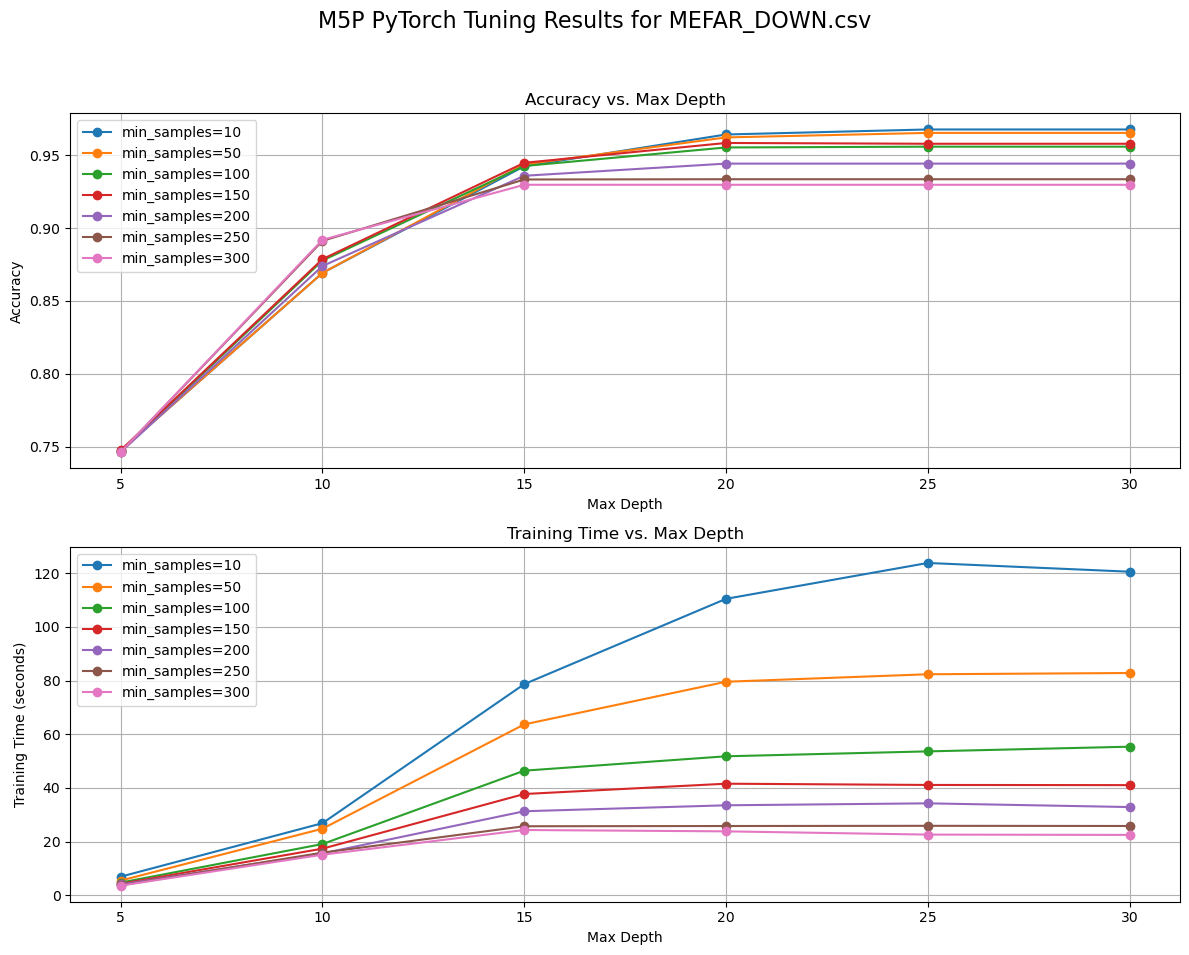


Best configuration for MEFAR_DOWN.csv:
  min_samples_split: 10.0
  max_depth: 25.0
  accuracy: 96.75%
  training_time: 123.88s

--- Starting M5P PyTorch Tuning for MEFAR_MID.csv ---
Loaded dataset: (923298, 18)
Features: 17, Samples: 923298

Progress: 1/42
Testing: min_samples=10, max_depth=5
Training M5P on 738638 samples with 17 features
Training completed
  Results: Accuracy= 74.37%, Time=6.46s

Progress: 2/42
Testing: min_samples=10, max_depth=10
Training M5P on 738638 samples with 17 features
Training completed
  Results: Accuracy= 89.41%, Time=39.26s

Progress: 3/42
Testing: min_samples=10, max_depth=15
Training M5P on 738638 samples with 17 features
Training completed
  Results: Accuracy= 97.32%, Time=171.76s

Progress: 4/42
Testing: min_samples=10, max_depth=20
Training M5P on 738638 samples with 17 features
Training completed
  Results: Accuracy= 99.68%, Time=313.49s

Progress: 5/42
Testing: min_samples=10, max_depth=25
Training M5P on 738638 samples with 17 features
Training

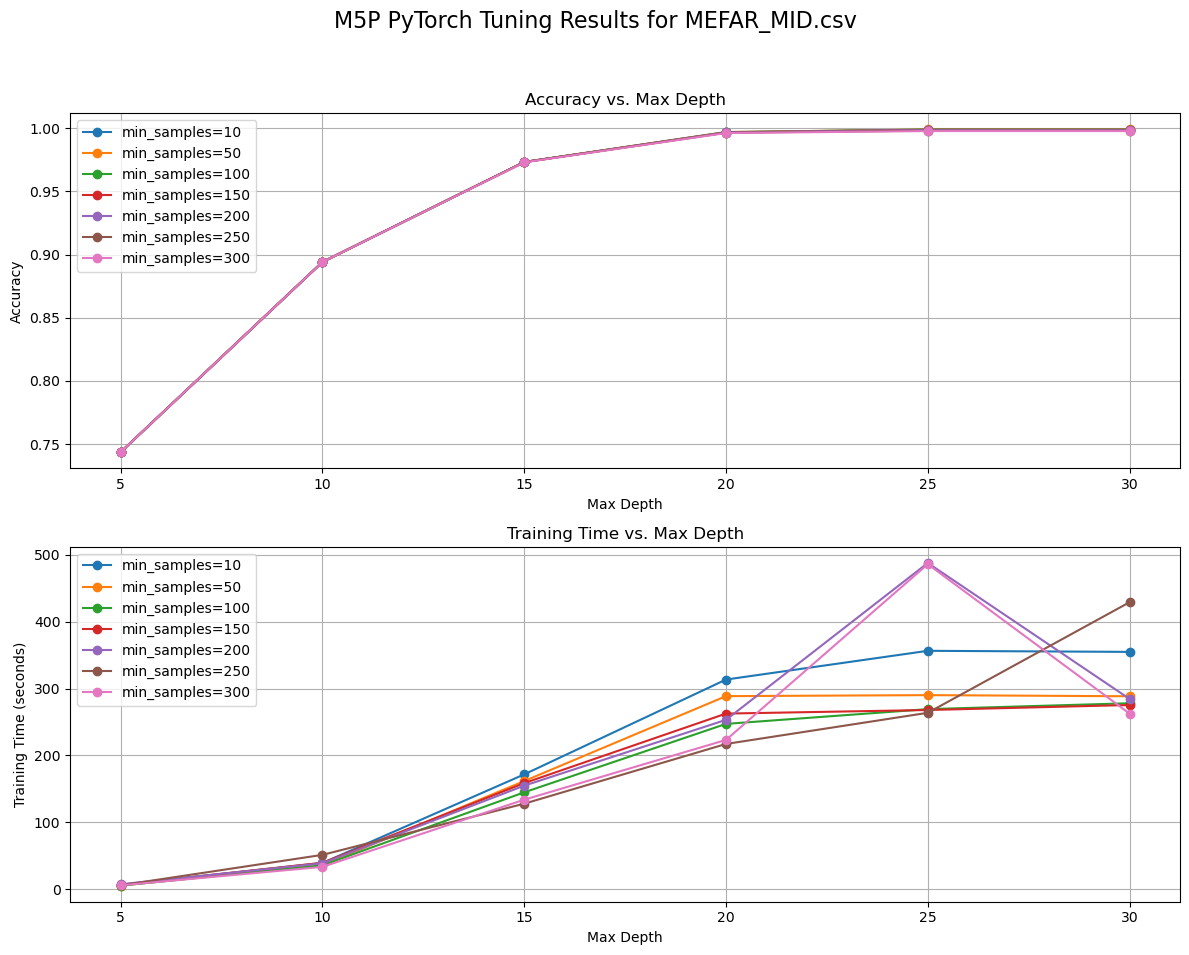


Best configuration for MEFAR_MID.csv:
  min_samples_split: 50.0
  max_depth: 30.0
  accuracy: 99.89%
  training_time: 288.51s

--- Starting M5P PyTorch Tuning for MEFAR_UP.csv ---
Loaded dataset: (1846590, 18)
Features: 17, Samples: 1846590

Progress: 1/42
Testing: min_samples=10, max_depth=5
Training M5P on 1477272 samples with 17 features
Training completed
  Results: Accuracy= 77.39%, Time=6.35s

Progress: 2/42
Testing: min_samples=10, max_depth=10
Training M5P on 1477272 samples with 17 features
Training completed
  Results: Accuracy= 91.49%, Time=36.18s

Progress: 3/42
Testing: min_samples=10, max_depth=15
Training M5P on 1477272 samples with 17 features
Training completed
  Results: Accuracy= 99.03%, Time=146.91s

Progress: 4/42
Testing: min_samples=10, max_depth=20
Training M5P on 1477272 samples with 17 features
Training completed
  Results: Accuracy= 99.94%, Time=550.00s

Progress: 5/42
Testing: min_samples=10, max_depth=25
Training M5P on 1477272 samples with 17 features
Tra

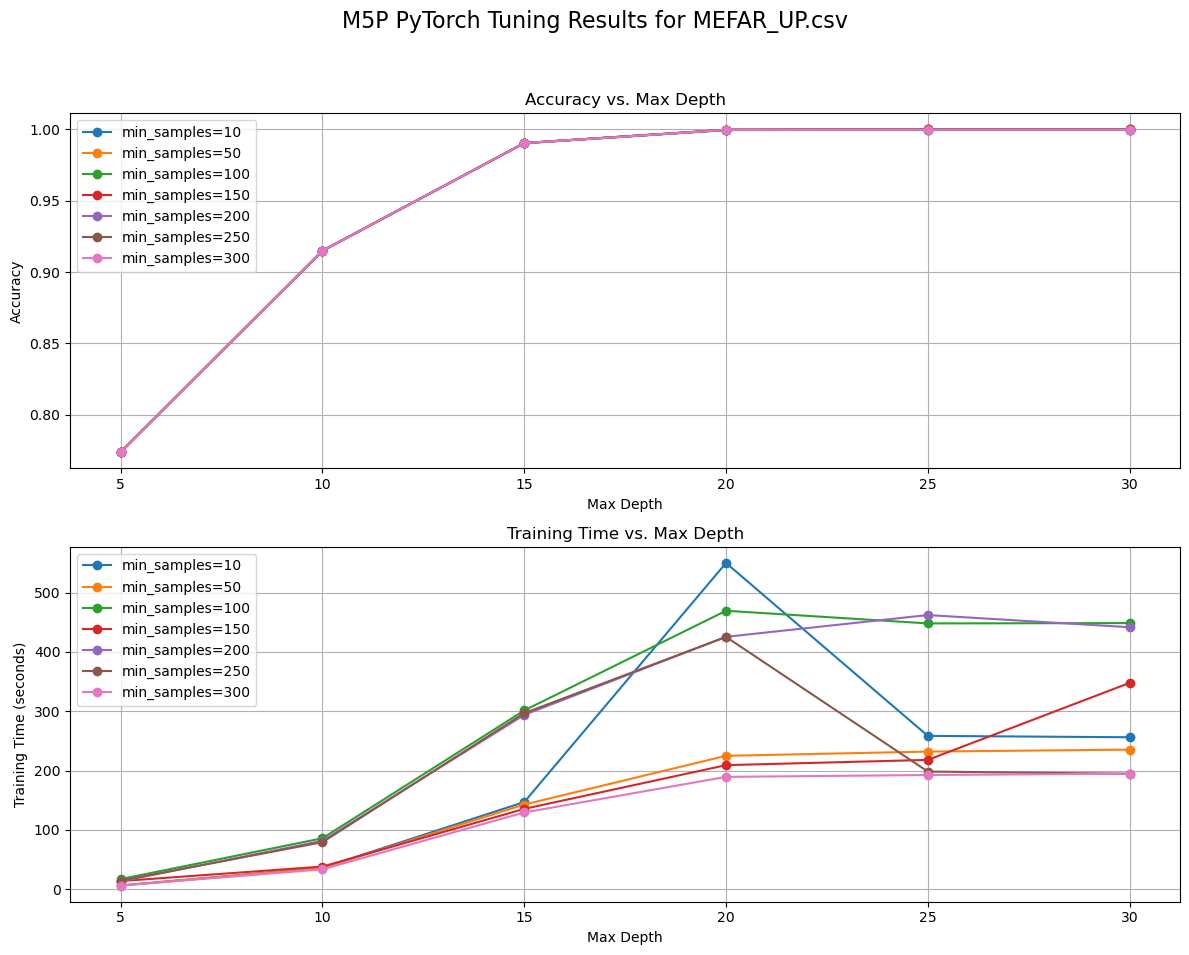


Best configuration for MEFAR_UP.csv:
  min_samples_split: 100.0
  max_depth: 25.0
  accuracy: 99.98%
  training_time: 448.09s


In [2]:
import pandas as pd
import time
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

class LinearRegression:
    def __init__(self):
        self.theta = None
        
    def fit(self, X, y):
        if X.numel() == 0 or y.numel() == 0:
            self.theta = None
            return
            
        try:
            # Add regularization for numerical stability
            X_b = torch.cat([torch.ones((X.shape[0], 1), device=X.device, dtype=X.dtype), X], dim=1)
            XTX = X_b.T @ X_b
            # Add small regularization term
            reg_term = 1e-8 * torch.eye(XTX.shape[0], device=X.device, dtype=X.dtype)
            XTX += reg_term
            self.theta = torch.linalg.solve(XTX, X_b.T @ y)
        except:
            # Fallback to pseudoinverse if solve fails
            try:
                X_b = torch.cat([torch.ones((X.shape[0], 1), device=X.device, dtype=X.dtype), X], dim=1)
                self.theta = torch.linalg.pinv(X_b) @ y
            except:
                self.theta = None
    
    def predict(self, X):
        if self.theta is None or X.numel() == 0:
            return torch.zeros(X.shape[0], device=X.device, dtype=X.dtype)
        X_b = torch.cat([torch.ones((X.shape[0], 1), device=X.device, dtype=X.dtype), X], dim=1)
        return X_b @ self.theta

class _Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None, model=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.model = model

    def is_leaf_node(self):
        return self.value is not None

class M5P(nn.Module):
    def __init__(self, min_samples_split=10, max_depth=10, min_samples_leaf=5):
        super(M5P, self).__init__()
        self.min_samples_split = max(2, min_samples_split)  # Ensure minimum of 2
        self.max_depth = max_depth
        self.min_samples_leaf = max(1, min_samples_leaf)
        self.root = None

    def _std_dev(self, y):
        if len(y) <= 1:
            return torch.tensor(0.0, device=y.device, dtype=y.dtype)
        return torch.std(y, unbiased=False)

    def _fast_best_split(self, X, y):
        """Optimized split finding with early stopping and sampling"""
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split:
            return None, None
            
        best_sdr = -1
        best_idx = None
        best_thresh = None
        parent_std = self._std_dev(y)
        
        # Early stopping if parent std is too small
        if parent_std < 1e-6:
            return None, None
        
        # Sample features if too many (for very high-dimensional data)
        if n_features > 50:
            feature_indices = torch.randperm(n_features, device=X.device)[:50]
        else:
            feature_indices = torch.arange(n_features, device=X.device)
        
        for feat_idx in feature_indices:
            feature_values = X[:, feat_idx]
            
            # Sort indices by feature values
            sorted_indices = torch.argsort(feature_values)
            sorted_y = y[sorted_indices]
            sorted_values = feature_values[sorted_indices]
            
            # Skip if all values are the same
            if torch.all(sorted_values == sorted_values[0]):
                continue
            
            # Find potential split points (where value changes)
            value_changes = torch.where(sorted_values[1:] != sorted_values[:-1])[0]
            
            if len(value_changes) == 0:
                continue
            
            # Limit number of splits to check (sample if too many)
            max_splits = min(50, len(value_changes))
            if len(value_changes) > max_splits:
                # Sample splits uniformly
                step = len(value_changes) // max_splits
                value_changes = value_changes[::step]
            
            for change_idx in value_changes:
                split_idx = change_idx + 1  # Split after the change point
                
                # Ensure minimum samples in each leaf
                if split_idx < self.min_samples_leaf or (n_samples - split_idx) < self.min_samples_leaf:
                    continue
                
                threshold = (sorted_values[change_idx] + sorted_values[split_idx]) / 2.0
                
                # Calculate standard deviation reduction
                y_left = sorted_y[:split_idx]
                y_right = sorted_y[split_idx:]
                
                left_std = self._std_dev(y_left)
                right_std = self._std_dev(y_right)
                
                weighted_std = (len(y_left) * left_std + len(y_right) * right_std) / n_samples
                sdr = parent_std - weighted_std
                
                if sdr > best_sdr:
                    best_sdr = sdr
                    best_idx = feat_idx.item()
                    best_thresh = threshold.item()
        
        return best_idx, best_thresh

    def _grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        
        # Stopping criteria
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            n_samples < 2 * self.min_samples_leaf or
            self._std_dev(y) < 1e-6):
            
            return self._create_leaf(X, y)

        feat_idx, thresh = self._fast_best_split(X, y)
        
        if feat_idx is None:
            return self._create_leaf(X, y)

        # Split the data
        left_mask = X[:, feat_idx] <= thresh
        right_mask = ~left_mask
        
        # Ensure both splits have minimum samples
        if torch.sum(left_mask) < self.min_samples_leaf or torch.sum(right_mask) < self.min_samples_leaf:
            return self._create_leaf(X, y)
        
        # Recursively build subtrees
        left_child = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return _Node(feat_idx, thresh, left_child, right_child)

    def _create_leaf(self, X, y):
        """Create a leaf node with linear regression model"""
        leaf_value = torch.mean(y)
        model = LinearRegression()
        
        # Only fit linear model if we have enough samples and features
        if X.shape[0] > X.shape[1] + 1 and X.shape[0] >= 5:
            model.fit(X, y)
        
        return _Node(value=leaf_value, model=model)

    def fit(self, X, y):
        """Fit the M5P model"""
        if len(X.shape) != 2 or len(y.shape) != 1:
            raise ValueError("X must be 2D and y must be 1D")
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have same number of samples")
        
        # Ensure proper data types
        X = X.float()
        y = y.float()
        
        print(f"Training M5P on {X.shape[0]} samples with {X.shape[1]} features")
        self.root = self._grow_tree(X, y)
        print("Training completed")

    def _traverse_tree(self, x, node):
        """Traverse tree for a single sample"""
        if node.is_leaf_node():
            if node.model and node.model.theta is not None:
                pred = node.model.predict(x.unsqueeze(0))
                return pred[0] if len(pred) > 0 else node.value
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def forward(self, X):
        """Predict using the fitted model"""
        if self.root is None:
            raise ValueError("Model must be fitted before prediction")
        
        predictions = torch.zeros(X.shape[0], device=X.device, dtype=X.dtype)
        
        # Batch prediction would be more complex due to tree structure
        # For now, keep individual predictions but optimize the traversal
        for i in range(X.shape[0]):
            predictions[i] = self._traverse_tree(X[i], self.root)
            
        return predictions

    def predict(self, X):
        """Predict method for sklearn compatibility"""
        with torch.no_grad():
            return self.forward(X)

def tune_and_plot_m5p_pytorch(file_path, min_samples_range, max_depth_range, device):
    """Optimized tuning function with better memory management"""
    filename = os.path.basename(file_path)
    print(f"\n--- Starting M5P PyTorch Tuning for {filename} ---")

    # Load and preprocess data
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded dataset: {df.shape}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return

    # Handle missing values
    if df.isnull().sum().sum() > 0:
        print("Handling missing values...")
        df = df.fillna(df.mean(numeric_only=True))
    
    # Prepare data
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # Handle potential data issues
    if np.isnan(X).any() or np.isnan(y).any():
        print("Warning: NaN values found after preprocessing")
        return
    
    print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to tensors
    X_train_pt = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_pt = torch.tensor(y_train, dtype=torch.float32, device=device)
    X_test_pt = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test_np = y_test

    results = []
    total_combinations = len(min_samples_range) * len(max_depth_range)
    current_combination = 0
    
    for min_samples in min_samples_range:
        for max_d in max_depth_range:
            current_combination += 1
            print(f"\nProgress: {current_combination}/{total_combinations}")
            print(f"Testing: min_samples={min_samples}, max_depth={max_d}")
            
            # Clear GPU memory
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            try:
                # Create and train model
                model = M5P(min_samples_split=min_samples, max_depth=max_d, min_samples_leaf=max(1, min_samples//2))
                model.to(device)
                
                start_time = time.time()
                model.fit(X_train_pt, y_train_pt)
                training_time = time.time() - start_time
                
                # Make predictions
                with torch.no_grad():
                    continuous_predictions = model(X_test_pt).cpu().numpy()
                
                # Convert to binary predictions (assuming binary classification)
                binary_predictions = (continuous_predictions > 0.5).astype(int)
                accuracy = accuracy_score(y_test_np, binary_predictions)
                
                results.append({
                    'min_samples_split': min_samples,
                    'max_depth': max_d,
                    'accuracy': accuracy,
                    'training_time': training_time
                })
                
                print(f"  Results: Accuracy={accuracy*100:6.2f}%, Time={training_time:.2f}s")
                
            except Exception as e:
                print(f"  Error with min_samples={min_samples}, max_depth={max_d}: {e}")
                results.append({
                    'min_samples_split': min_samples,
                    'max_depth': max_d,
                    'accuracy': 0.0,
                    'training_time': float('inf')
                })

    # Create plots
    if results:
        df_results = pd.DataFrame(results)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        fig.suptitle(f'M5P PyTorch Tuning Results for {filename}', fontsize=16)
        
        # Plot accuracy
        for min_val in min_samples_range:
            subset = df_results[df_results['min_samples_split'] == min_val]
            if not subset.empty:
                ax1.plot(subset['max_depth'], subset['accuracy'], 
                        marker='o', label=f'min_samples={min_val}')
        
        ax1.set_title('Accuracy vs. Max Depth')
        ax1.set_xlabel('Max Depth')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Plot training time
        for min_val in min_samples_range:
            subset = df_results[df_results['min_samples_split'] == min_val]
            valid_subset = subset[subset['training_time'] != float('inf')]
            if not valid_subset.empty:
                ax2.plot(valid_subset['max_depth'], valid_subset['training_time'], 
                        marker='o', label=f'min_samples={min_val}')

        ax2.set_title('Training Time vs. Max Depth')
        ax2.set_xlabel('Max Depth')
        ax2.set_ylabel('Training Time (seconds)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Print best configuration
        best_config = df_results.loc[df_results['accuracy'].idxmax()]
        print(f"\nBest configuration for {filename}:")
        print(f"  min_samples_split: {best_config['min_samples_split']}")
        print(f"  max_depth: {best_config['max_depth']}")
        print(f"  accuracy: {best_config['accuracy']*100:.2f}%")
        print(f"  training_time: {best_config['training_time']:.2f}s")

# Main execution with optimized parameters
if __name__ == "__main__":
    DATASET_PATH = '../Datasets'
    
    # More conservative hyperparameter ranges for faster tuning
    min_samples_values = [10, 50, 100, 150, 200, 250, 300]  # Start with larger values
    max_depth_values = [5, 10, 15, 20, 25, 30]  # Reduced depth range
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    if os.path.exists(DATASET_PATH):
        dataset_files = [os.path.join(DATASET_PATH, f) 
                        for f in os.listdir(DATASET_PATH) 
                        if f.endswith('.csv')]
        
        for file in dataset_files:
            tune_and_plot_m5p_pytorch(
                file_path=file,
                min_samples_range=min_samples_values,
                max_depth_range=max_depth_values,
                device=device
            )
    else:
        print(f"Dataset path {DATASET_PATH} not found!")